In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [2]:
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm
0,0,70,2,21,2,3,48,66
1,1,56,2,12,2,7,61,77
2,1,58,2,35,2,9,52,271
3,1,59,2,17,2,4,60,29
4,0,73,2,35,2,1,26,65
...,...,...,...,...,...,...,...,...
681,0,49,1,30,3,3,1,84
682,1,53,2,25,3,17,0,0
683,0,51,1,25,3,5,43,0
684,0,52,2,23,2,3,15,34


In [3]:
# X = X[["max_ESR", "gender", "age"]].dropna()
# X["ref_ESR"] = X["max_ESR"] < 20
# X = X[(X["gender"] == 1) & (X["age"] > 50)].reset_index()
# y = y[X.index]

# feat = "ref_ESR"  # Wuhan

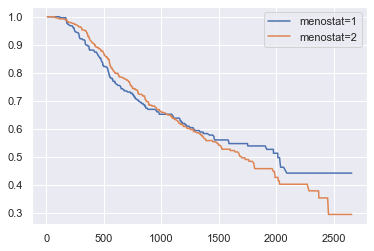

In [6]:
feat = "menostat"  # GBSG (tumgrad)
# feat = "sex"  # PBC

bins = np.unique(y["time"])

fig = plt.figure()
for v in np.unique(X[feat]):
    index = X.query(f"{feat} == {v}").index
    
    kmf = KaplanMeierFitter()
    kmf.fit(y[index]['time'], event_observed=y[index]['cens'])
    sf_train = kmf.survival_function_at_times(bins).to_numpy()
    plt.plot(bins, sf_train, label=f"{feat}={v}")
plt.legend()

<AxesSubplot:>

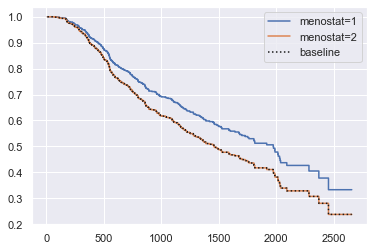

In [5]:
from lifelines import CoxPHFitter
df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

cph = CoxPHFitter().fit(df, 'time', 'cens')  # strata=[feat]
cph.plot_partial_effects_on_outcome(feat, values=np.unique(X[feat]))

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
         test_name = proportional_hazard_test

---
               test_statistic    p  -log2(p)
age      km              2.78 0.10      3.39
         rank            2.65 0.10      3.27
esm      km              0.91 0.34      1.56
         rank            1.32 0.25      2.00
htreat   km              0.17 0.68      0.55
         rank            0.17 0.68      0.55
menostat km              0.01 0.92      0.13
         rank            0.03 0.87      0.20
posnodal km              0.72 0.40      1.34
         rank            0.70 0.40      1.31
prm      km              1.39 0.24      2.07
         rank            1.25 0.26      1.92
tumgrad  km              4.43 0.04      4.82
         rank            5.57 0.02      5.78
tumsize  km              0.24 0.62      0.68
         rank            0.24 0.62      0.68



1. Variable 'tumgrad' failed the non-proportional test: p-value is 0.0182.

   Advice: with so few unique values (only 3), you can include `strata=['tumgrad', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0182)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0353)'>]]

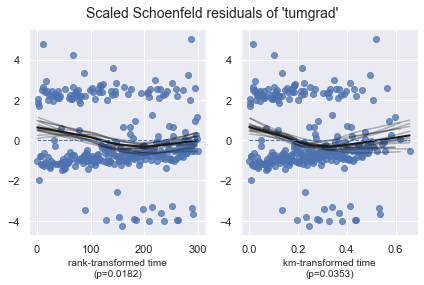

In [7]:
cph.check_assumptions(df, p_value_threshold=0.05, show_plots=True)